In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
file_path = "/bin/EDA/Cardiovascular_Disease_Dataset.csv"
df = pd.read_csv(file_path)

# 1. Remove duplicate rows (if any)
df = df.drop_duplicates()

# 2. Handle missing or incorrect values
df['serumcholestrol'] = df['serumcholestrol'].replace(0, np.nan)  # Replace 0 with NaN
df['serumcholestrol'] = df['serumcholestrol'].fillna(df['serumcholestrol'].median())  # Fill with median

# 3. Convert categorical numerical labels to meaningful labels
df['gender'] = df['gender'].map({1: 'Male', 0: 'Female'})
df['exerciseangia'] = df['exerciseangia'].map({1: 'Yes', 0: 'No'})
df['fastingbloodsugar'] = df['fastingbloodsugar'].map({1: 'High', 0: 'Normal'})
df['target'] = df['target'].map({1: 'Disease', 0: 'No Disease'})

# 4. Outlier Detection and Removal using IQR method (Ensuring float type)
def remove_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].astype(float)  # Ensure column allows float
    df.loc[df[col] < lower_bound, col] = lower_bound
    df.loc[df[col] > upper_bound, col] = upper_bound

num_cols = ['age', 'restingBP', 'serumcholestrol', 'maxheartrate', 'oldpeak', 'noofmajorvessels']
for col in num_cols:
    remove_outliers(col)

# 5. Feature Selection (Remove highly correlated features)
numeric_df = df.select_dtypes(include=[np.number])  # Keep only numeric columns
corr_matrix = numeric_df.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)]
df.drop(high_corr_features, axis=1, inplace=True)

# 6. Normalize numerical columns using Min-Max Scaling
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 7. Encode categorical variables for ML compatibility
df_encoded = pd.get_dummies(df, columns=['gender', 'chestpain', 'restingrelectro', 'slope'])

# Save the cleaned dataset
cleaned_file_path = "/bin/EDA/Cardiovascular_Disease_Dataset.csv"
df_encoded.to_csv(cleaned_file_path, index=False)

print("Preprocessing Completed. Cleaned dataset saved.")

Preprocessing Completed. Cleaned dataset saved.


# New Section

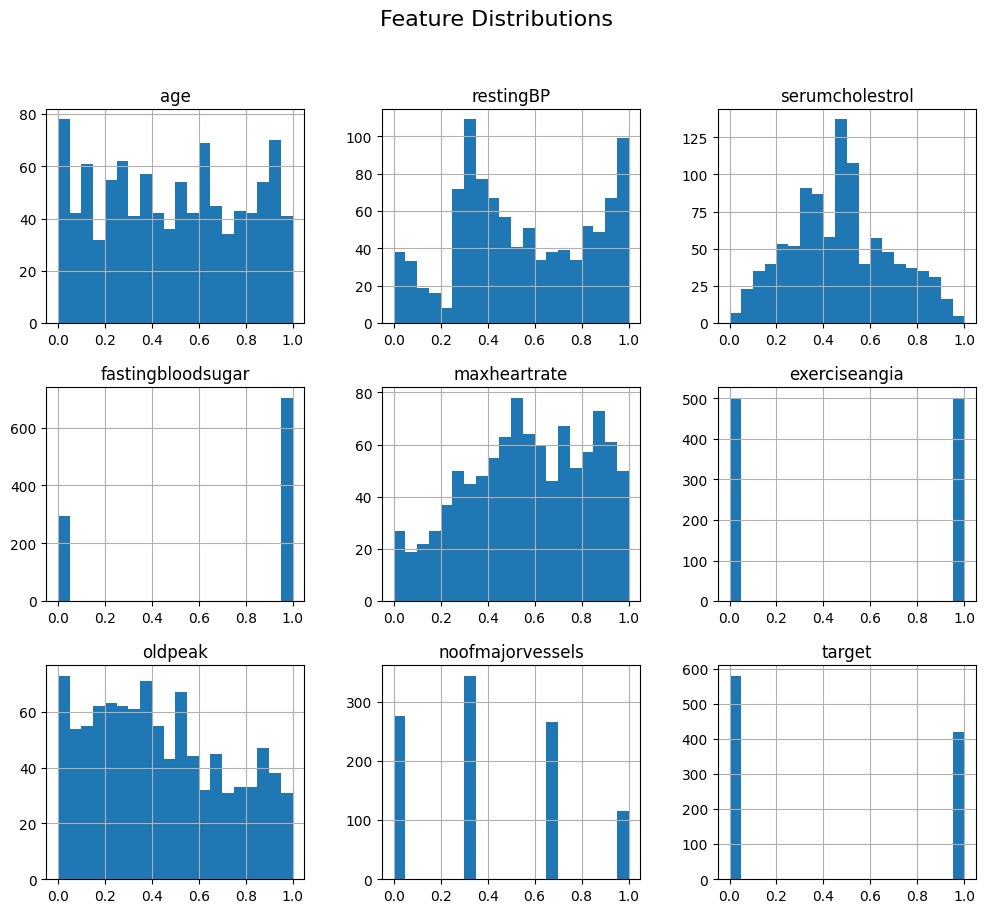

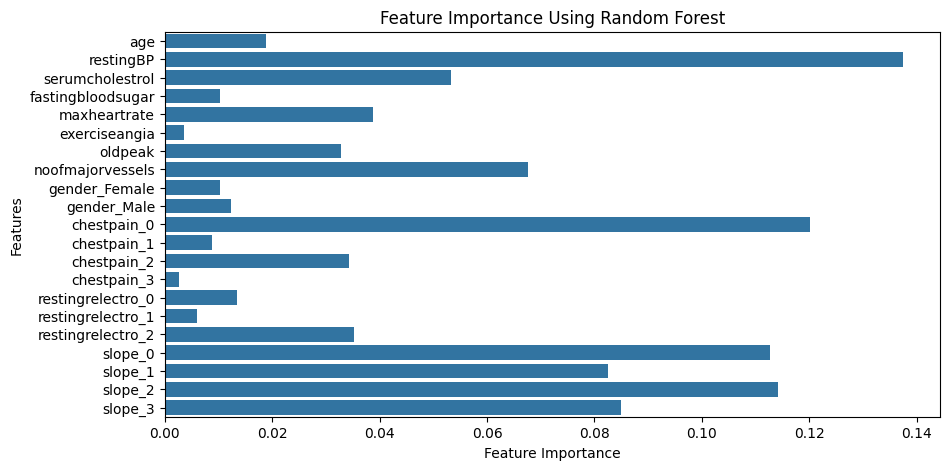


Model: Logistic Regression
Accuracy: 0.9650
Precision: 0.9750
Recall: 0.9398
F1-score: 0.9571

Model: Support Vector Machine (SVM)
Accuracy: 0.9550
Precision: 0.9405
Recall: 0.9518
F1-score: 0.9461

Model: Decision Tree
Accuracy: 0.9450
Precision: 0.9286
Recall: 0.9398
F1-score: 0.9341

Model: Random Forest
Accuracy: 0.9700
Precision: 0.9529
Recall: 0.9759
F1-score: 0.9643


<ipython-input-13-c6d5dc23358a>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=[results[model]["Accuracy"] for model in results], palette="coolwarm")


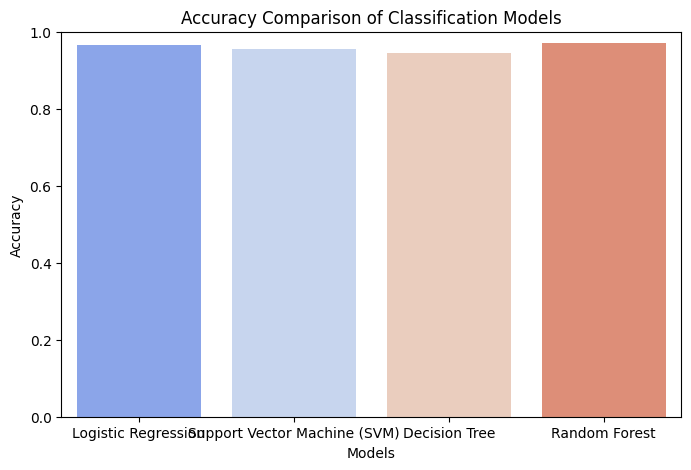

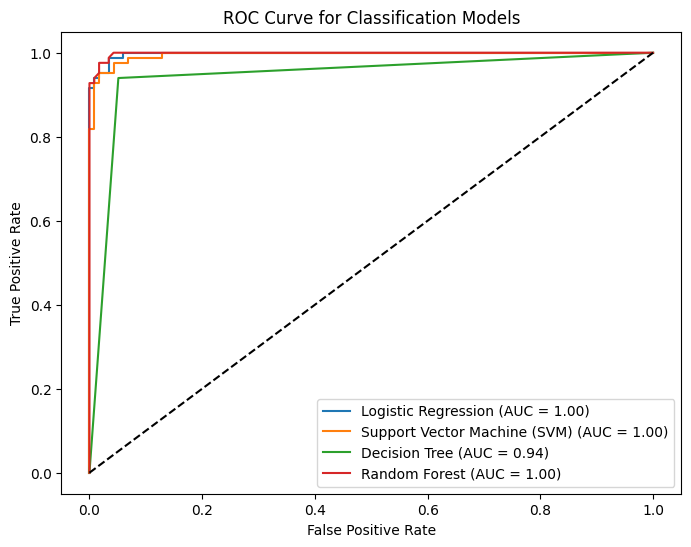

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Load the dataset (Replace 'your_dataset.csv' with your actual file)
df = pd.read_csv("/bin/EDA/Cardiovascular_Disease_Dataset.csv")

# ---- EDA: Handle Categorical Data ----
# Convert categorical columns into numerical values using Label Encoding
categorical_columns = ["fastingbloodsugar", "exerciseangia", "target"]
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Drop non-informative column (patientid) if it exists
if 'patientid' in df.columns:
    df = df.drop(columns=['patientid'])

# ---- EDA: Feature Distribution ----
df.hist(figsize=(12, 10), bins=20)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


# ---- Feature Importance Using Random Forest ----
X = df.drop(columns=['target'])  # Features
y = df['target']  # Target variable

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Plot feature importance
importances = rf.feature_importances_
features = X.columns

plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=features)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Using Random Forest")
plt.show()

# ---- Data Splitting and Scaling ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---- Classification Models ----
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine (SVM)": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    results[name] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-score": f1}

    print(f"\nModel: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

# ---- Graph: Accuracy Comparison ----
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=[results[model]["Accuracy"] for model in results], palette="coolwarm")
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.title("Accuracy Comparison of Classification Models")
plt.ylim(0, 1)  # Accuracy ranges between 0 and 1
plt.show()

# ---- ROC Curve ----
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Classification Models")
plt.legend()
plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')